# Orbital Mechanics with Orekit 

**Western Sydney University** 

*The MARCS Institute for Brain, Behaviour and Development, Biomedical Engineering and Neuromorphic Systems (BENS)* 


<br>


***



This notebook is based on the following:

**Orekit jupyter notebooks**

 - http://nbviewer.jupyter.org/urls/www.orekit.org/forge/projects/orekit-python-wrapper/repository/revisions/master/raw/examples/orekit%20map.ipynb

 - http://nbviewer.jupyter.org/urls/www.orekit.org/forge/projects/orekit-python-wrapper/repository/revisions/master/raw/examples/TLE%20Propagation.ipynb?create=1

**Orekit Gitlab jupyter notebooks**

 - https://gitlab.orekit.org/orekit-labs/python-wrapper/blob/master/examples/orekit_map.ipynb

 - https://gitlab.orekit.org/orekit-labs/python-wrapper/blob/master/examples/Example_EarthObservation_-_Attitude_Sequence.ipynb

 - https://gitlab.orekit.org/orekit-labs/python-wrapper/blob/master/examples/Example_numerical_prop.ipynb

 - https://gitlab.orekit.org/orekit-labs/python-wrapper/blob/master/examples/NodeDetectorTest.py

 - https://gitlab.orekit.org/orekit-labs/python-wrapper/blob/master/examples/TLE_Propagation.ipynb

**Orekit main resources and function reference** 

 - https://www.orekit.org/static/apidocs/overview-summary.html

 - https://www.orekit.org/static/apidocs/org/orekit/frames/FramesFactory.html#EOPC04_2000_FILENAME



**Install Orekit using Anaconda:**

>conda create -n orekit python=3.6


 - Orekit can be installed with one of the following:

>conda install -c conda-forge orekit
>conda install -c conda-forge/label/gcc7 orekit
>conda install -c conda-forge/label/broken orekit 


 - For the fancy earth map overlays, install mpl_toolkits.basemap using:

>conda install basemap 
>conda install ioos geopandas 
>conda install conda-forge proj4

 - For 3D projection of orbit:

>conda install plotly


**Basic use and installation of Orekit**

The orekit library needs a data file with various information on time and earth rotation parameters. This file, called orekit-data.zip is loaded from current dir. 

A version of this file can be downloaded from the orekit webpage:
https://www.orekit.org/forge/projects/orekit/files
called "orekit-data.zip"

Place this in the directory of the notebook

This routine is commonly used in the notebooks, so a python specific function is created for this, setup_orekit_curdir()




In [50]:
#orekit python wrapper library and resources 
import orekit
orekit.initVM()

from orekit.pyhelpers import setup_orekit_curdir
setup_orekit_curdir()

from org.orekit.data import DataProvidersManager, ZipJarCrawler
from org.orekit.frames import FramesFactory, TopocentricFrame, EOPEntry, EOPHistoryLoader
from org.orekit.bodies import OneAxisEllipsoid, GeodeticPoint
from org.orekit.time import TimeScalesFactory, AbsoluteDate, DateComponents, TimeComponents
from org.orekit.utils import IERSConventions, Constants

from org.orekit.propagation.analytical.tle import TLE, TLEPropagator
from org.orekit.propagation.analytical.gnss import GPSPropagator

from org.orekit.estimation.measurements import AngularAzEl

from java.io import File

In [51]:
#basic utilities
import numpy as np
from math import radians, pi

#tabulating 
import pandas as pd 
import geopandas

#plotting imports 
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

#plotting import basemap for detailed map figures 
from mpl_toolkits.basemap import Basemap
from mpl_toolkits import mplot3d

#plotting plotly for 3D figure of propogated orbit 
from plotly import __version__
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


# Define the TLE of an object 

The **Two Line Element** of an object or **TLE**, is a data format encoding a list of orbital elements of an Earth-orbiting object for a given point or epoch in time. 

 - Using suitable prediction formula, the state (position and velocity) at any point in the past or future can be estimated to some accuracy. 

- The TLE data representation is specific to the simplified perturbations models (SGP, SGP4, SDP4, SGP8 and SDP8), so any algorithm using a TLE as a data source must implement one of the SGP models to correctly compute the state at a time of interest. 

- TLEs can describe the trajectories only of Earth-orbiting objects and are widely used as input for projecting the future orbital tracks 
 



**TLEs follows a strict format:**

AAAAAAAAAAAAAAAAAAAAAAAA
 - 1 NNNNNU NNNNNAAA NNNNN.NNNNNNNN +.NNNNNNNN +NNNNN-N +NNNNN-N N NNNNN
 - 2 NNNNN NNN.NNNN NNN.NNNN NNNNNNN NNN.NNNN NNN.NNNN NN.NNNNNNNNNNNNNN

Line 0 is a twenty-four character name (to be consistent with the name length in the NORAD SATCAT).

Lines 1 and 2 are the standard Two-Line Orbital Element Set Format identical to that used by NORAD and NASA. The format description is:


Line 1
Column 	Description
 - 01 	Line Number of Element Data
 - 03-07 	Satellite Number
 - 08 	Classification (U=Unclassified)
 - 10-11 	International Designator (Last two digits of launch year)
 - 12-14 	International Designator (Launch number of the year)
 - 15-17 	International Designator (Piece of the launch)
 - 19-20 	Epoch Year (Last two digits of year)
 - 21-32 	Epoch (Day of the year and fractional portion of the day)
 - 34-43 	First Time Derivative of the Mean Motion
 - 45-52 	Second Time Derivative of Mean Motion (decimal point assumed)
 - 54-61 	BSTAR drag term (decimal point assumed)
 - 63 	Ephemeris type
 - 65-68 	Element number
 - 69 	Checksum (Modulo 10)
 - (Letters, blanks, periods, plus signs = 0; minus signs = 1)


Line 2
Column 	Description
 - 01 	Line Number of Element Data
 - 03-07 	Satellite Number
 - 09-16 	Inclination [Degrees]
 - 18-25 	Right Ascension of the Ascending Node [Degrees]
 - 27-33 	Eccentricity (decimal point assumed)
 - 35-42 	Argument of Perigee [Degrees]
 - 44-51 	Mean Anomaly [Degrees]
 - 53-63 	Mean Motion [Revs per day]
 - 64-68 	Revolution number at epoch [Revs]
 - 69 	Checksum (Modulo 10)



Up to date TLE's of prominent objects can be found at: <a href= https://www.celestrak.com/NORAD/elements/stations.txt> Celestrack </a>


<br>


<center> Text Source: <a href= https://www.celestrak.com/NORAD/documentation/tle-fmt.php> Link 1 </a> and <a href= https://en.wikipedia.org/wiki/Two-line_element_set> Link 2 </a> <center> 



<br>

***

In [52]:
#define the TLE of the ISS and the NOAA 20 (JPSS 1)

#Zarya - ISS 
tle_line1 = '1 25544U 98067A   18322.51199823  .00001342  00000-0  27682-4 0  9993'
tle_line2 = '2 25544  51.6421 329.6729 0005208  60.1231  93.6091 15.53980115142516'


# NOAA 20 (JPSS 1) 
# tle_line1 = '1 43013U 17073A   18321.87489745  .00000005  00000-0  23331-4 0  9997'
# tle_line2 = '2 43013  98.7392 258.0048 0001226 102.8509 257.2804 14.19552144 51712'



In [53]:
#Parse the TLE lines to an orekit TLE object 
zarya = TLE(tle_line1,tle_line2)

#print the TLE object and epoch data 
print('TLE Lines 1 and 2:\n')

print(zarya)
 
print('\nEpoch :',zarya.getDate())

TLE Lines 1 and 2:

1 25544U 98067A   18322.51199823  .00001342  00000-0  27682-4 0  9993
2 25544  51.6421 329.6729 0005208  60.1231  93.6091 15.53980115142516

Epoch : 2018-11-18T12:17:16.647


***
# Fundamental Coordinate Frames 

Coordinate frames and transformations are key to astronomy and orbital mechanics. We need to consider a number of cartesian and spherical frames.

Starting in the basics with spherical coordinate frames:

 - A spherical coordinate frame is a coordinate system for three-dimensional space where the position of a point is specified by three numbers:
  -  The radial distance of that point from a fixed origin,
  -  its polar angle measured from a fixed zenith direction, and
  -  the azimuth angle of its orthogonal projection on a reference plane that passes through the origin and is orthogonal to the zenith, measured from a fixed reference direction on that plane. 
  -  These angles may be in degrees or radians. Fractional degrees are also often used with archours (degrees), arcminutes (degrees/60) and arcseconds (degrees/60/60). Arc is used here to differentiate between hours, minutes and seconds as units of time. 

As shown in the figure below, it can be seen as the three-dimensional version of the polar coordinate system. 

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/4/4f/3D_Spherical.svg/558px-3D_Spherical.svg.png width='200'  title='Spherical Coordinate System'>

<center> Spherical Coordinate Frame. <a href= https://en.wikipedia.org/wiki/Spherical_coordinate_system> Image and Text Source </a>  <center> 

<br> 
***




# Geographic Coordinate System 

A **geographic coordinate system** is a coordinate system used in geography that enables every location on Earth to be specified by a vertical position, and two or three of the numbers represent a horizontal position. A common choice of coordinates is latitude, longitude and elevation.

<img src=https://cdn.shopify.com/s/files/1/0293/8205/files/latitude_longitude_grande.gif?12060491192372930797 width='500'> 


<center> Geographic coordinate system defined typically using latitude and longitude. <a href= https://60n95w.com/blogs/oh60n95w/17378537-latitude-and-longitude-basics-for-the-modern-explorer> Image Source </a>  
    
<br>

***



There are a number of these coordinate systems:

 - **Local east, north, up (ENU) coordinates**
  -  The local ENU coordinates convenient for tracking and are formed from a plane tangent to the Earth's surface fixed to a specific location and hence it is sometimes known as a "Local Tangent" or "local geodetic" plane. 
  -  By convention the east axis is labelled x, the north y and the up z. 
  

 - **Local north, east, down (NED) coordinates**
  -  An alternative to the ENU local tangent plane where in an airplane, most objects of interest are below the aircraft, so it is sensible to define down as a positive number. 
  -  The North, East, Down (NED) coordinates allow this as. By convention, the north axis is labeled x', the east y' and the down z'. 
-  Also known as local tangent plane (LTP). 

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/7/73/ECEF_ENU_Longitude_Latitude_relationships.svg/520px-ECEF_ENU_Longitude_Latitude_relationships.svg.png width='300'>


<center> Earth Centered Earth Fixed and East, North, Up coordinates. <a href= https://en.wikipedia.org/wiki/Geographic_coordinate_system> Image and Text Source </a>  
    
    

<br>



 - **Earth Centered Earth Fixed frame (ECEF)**
  -  A **geocentric** and cartesian coordinate system and is sometimes known as a **"conventional terrestrial system"**, which is the reference frame for GPS satellites. 

  -  As a cartesian system, the ECEF represents positions as X, Y, and Z coordinates. The point (0, 0, 0) is defined as the center of mass of Earth, hence the term geocentric coordinates. 


<img src=https://upload.wikimedia.org/wikipedia/commons/8/88/Ecef.png width='600'>

<center> Earth Centered, Earth Fixed coordinates in relation to latitude and longitude. <a href= https://en.wikipedia.org/wiki/ECEF#In_astronomy> Image and Text Source </a>  
    





<br>


***

Contrasted to the ECEF, the **Earth-centered inertial (ECI)** coordinate frame is also used. This frame has its origin at the center of mass of Earth and does not rotate with respect to the stars as the x-axis is permanently fixed in a direction relative to the celestial sphere 



<img src=https://upload.wikimedia.org/wikipedia/commons/3/32/Earth_Centered_Inertial_Coordinate_System.png width='400'>

<center> ECI coordinate frame system. <a href=https://en.wikipedia.org/wiki/Earth-centered_inertial> Image and Text Source </a>  

There are a number of these coordinate systems, including:

 - **J2000**
  -  The J2000 ECI frame is defined with the Earth's Mean Equator and Equinox at 12:00 Terrestrial Time on 1 January 2000. It can be referred to as J2000 or EME2000. 
  -  The x-axis is aligned with the mean equinox. The z-axis is aligned with the Earth's spin axis or celestial North Pole. The y-axis is rotated by 90° East about the celestial equator.


 - **M50**
  -  This frame is similar to J2000, but is defined with the mean equator and equinox at 12:00 on 1 January 1950.


 - **GCRF**
  -  Geocentric Celestial Reference Frame (GCRF) is the Earth-centered counterpart of the International Celestial Reference Frame.


 - **MOD**
  -  A Mean of Date (MOD) frame is defined using the mean equator and equinox on a particular date.


 - **TEME**
  -  The ECI frame used for the NORAD two-line elements is sometimes called true equator, mean equinox (TEME) although it does not use the conventional mean equinox. 



Other commonly used geographic coordinate systems include the **geodetic system**:

 - The **geodetic datum** or **geodetic system** is a coordinate system, and a set of reference points, used to locate places on the Earth (or similar objects).
  -  In geodetic coordinates, the Earth's surface is approximated by an ellipsoid, and locations near the surface are also described in terms of latitude, longitude and height. 
  -  An approximate definition of sea level is the datum WGS 84, an ellipsoid, whereas a more accurate definition is Earth Gravitational Model 2008 (EGM2008), using at least 2,159 spherical harmonics. Other datums are defined for other areas or at other times




<img src=https://au.mathworks.com/matlabcentral/mlc-downloads/downloads/submissions/61958/versions/1/screenshot.png width='400'>

<center> Standard ECI coordinate frame with a fixed origin at the centre of the earth. <a href=https://au.mathworks.com/matlabcentral/fileexchange/61958-geodetic-coordinates> Image Source</a> and <a href=https://en.wikipedia.org/wiki/Geodetic_datum#Geodetic_coordinates> Text Source </a>  


<br>

***

The most current interpretation of the ECI is the **International Terrestrial Reference Frame (ITRF)**.

This is the current (as of 2013) reference produced by the International Earth Rotation and Reference Systems Service (IERS) and is described in IERS conventions (2010). 

This frame takes into account a set of **Earth Orientation Parameters (EOP)**, as a collection of parameters that describe irregularities in the rotation of the Earth, variations in gravity and tectonic motion for greater accuracy in analysis. 


<img src=http://deacademic.com/pictures/dewiki/51/370px-Geoids_sm.jpg width='400'>

<center> Local fluctuations in Earth's gravitational influence. <a href=http://deacademic.com/dic.nsf/dewiki/1558295> Image Source </a>  
    

<img src=https://spotlight.unavco.org/how-gps-works/gps-basics/gps-reference-frames_files/itrf.png width='400'>

<center> The apparent tectonic motion of Earth's upper mantle and crust. <a href=https://spotlight.unavco.org/how-gps-works/gps-basics/gps-reference-frames.html> Image Source </a>  
    

<br>

***

**Putting this practice, we can define the earth ITRF and create an ellipsoid object in oreket to represent it. We can also make an inertial frame using an Orekit TEME frame factory:**

In [54]:
#get the earth ITRF according to 2010 IERS conventions 
ITRF = FramesFactory.getITRF(IERSConventions.IERS_2010, True)

#create an Orekit Ellipsoid object for Earth using the defined ITRF, equatorial radius and flattening constants 
earth = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS, 
                         Constants.WGS84_EARTH_FLATTENING, 
                         ITRF)


#create the true equator, mean equinox (TEME) earth-centred inertial frame  
inertialFrame = FramesFactory.getTEME()
# inertialFrame = FramesFactory.getEME2000()

In addition to these frames, there are also several **Celestial Coordinate Systems**:


 - **Horizontal system**
  -  The horizontal, **topocentric** or **Altitude-Azimuth (Alt/Az)** and **Azimuth-Elevation (Az/El)**, system is based on the position of the observer on Earth, which revolves around its own axis once per sidereal day (23 hours, 56 minutes and 4.091 seconds) in relation to the star background. 
  -  The positioning of a celestial object by the horizontal system varies with time, but is a useful coordinate system for locating and tracking objects for observers on Earth. It is based on the position of stars relative to an observer's ideal horizon. 
  -  Coordinates of an object in the sky using this system are expressed in terms of altitude (or elevation) angle and azimuth. This is often called **Az-El**, as Azimuth-Elevation.  


<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/f/f7/Azimuth-Altitude_schematic.svg/436px-Azimuth-Altitude_schematic.svg.png width='400'>

<center> The horizontal celestial coordinate system, also known as topocentric, Az/El and Alt/Az system. <a href=https://en.wikipedia.org/wiki/Horizontal_coordinate_system> Image and Text Source </a>  

 - **Equatorial system**
  -  The equatorial coordinate system is centered at Earth's center, but fixed relative to the celestial poles and the vernal equinox as **Right Ascension** and **Declination**
  -  The coordinates are based on the location of stars relative to Earth's equator if it were projected out to an infinite distance. The equatorial describes the sky as seen from the solar system, and modern star maps almost exclusively use equatorial coordinates.
  -  The equatorial system is the normal coordinate system for most professional and many amateur astronomers having an equatorial mount that follows the movement of the sky during the night. Celestial objects are found by adjusting the telescope's or other instrument's scales so that they match the equatorial coordinates of the selected object to observe.
  -  Popular choices of pole and equator are the older B1950 and the modern J2000 systems, but a pole and equator "of date" can also be used, meaning one appropriate to the date under consideration, such as when a measurement of the position of a planet or spacecraft is made. There are also subdivisions into "mean of date" coordinates, which average out or ignore nutation, and "true of date," which include nutation. 

<img src=https://upload.wikimedia.org/wikipedia/commons/9/98/Ra_and_dec_on_celestial_sphere.png width='400'>

<center> The equatorial celestial coordinate system. <a href=https://en.wikipedia.org/wiki/Right_ascension> Image and Text Source </a>  

 - **Ecliptic system**
  -  The fundamental plane is the plane of the Earth's orbit, called the ecliptic plane. There are two principal variants of the ecliptic coordinate system: geocentric ecliptic coordinates centered on the Earth and heliocentric ecliptic coordinates centered on the center of mass of the solar system.
  -  The geocentric ecliptic system was the principal coordinate system for ancient astronomy and is still useful for computing the apparent motions of the Sun, Moon, and planets.
  -  The heliocentric ecliptic system describes the planets' orbital movement around the Sun, and centers on the barycenter of the solar system (i.e. very close to the center of the Sun). The system is primarily used for computing the positions of planets and other solar system bodies, as well as defining their orbital elements. 


 - **Galactic system**
  -  The galactic coordinate system uses the approximate plane of our galaxy as its fundamental plane. The solar system is still the center of the coordinate system, and the zero point is defined as the direction towards the galactic center. Galactic latitude resembles the elevation above the galactic plane and galactic longitude determines direction relative to the center of the galaxy.


 - **Supergalactic system**
  -  The supergalactic coordinate system corresponds to a fundamental plane that contains a higher than average number of local galaxies in the sky as seen from Earth. 





<center><a href=https://en.wikipedia.org/wiki/Celestial_coordinate_system> Text Source </a> 
<br>


***



**These concepts can be applied in Orekit to define the geographic, geodetic and topocentric coordinates of the observating station:**

In [55]:
#WSU werrington observatory position in the geographic coordinate frame

longitude = radians(-33.4543)  #radians(DD)
latitude  = radians(150.4428)  #radians(DD)
altitude  = 56.0               #Elevation (m)

#convert from the geographic coordinates to geodetic coordinates
station_wsu_geod = GeodeticPoint(latitude, longitude, altitude)

#convert from the geodetic to the topocentric coordinate frame 
station_wsu_topoframe = TopocentricFrame(earth, station_wsu_geod, "Esrange")



***
# Time Standards and Systems





There are several time standards and systems currently in use:


 - TAI International Atomic Time: 
  -  Primary time standard in the world today.


 - UTC Coordinated Universal Time: 
  - Time broadcast by WWV and other services. By definition, UTC and TAI have the same rate but UTC stays close to Mean Solar Time by adding integer numbers of seconds, called leap seconds,from time to time.
  -  UTC is related to TAI using step adjustments from time to time according to IERS (International Earth Rotation Service) rules which require the introduction of leap seconds. 
    
    
 - TDT or TT - Terrestrial Dynamic Time:
  -  Terrestrial Time is  the coordinate time at the surface of the Earth as defined by IAU(1991) and is the successor of Ephemeris Time TE tied to atomic time by a constant offset of 32.184 seconds.
  -  By convention, TT = TAI + 32.184 s. 


 - TDB - Barycentric Dynamic Time:
  -  Barycentric Dynamic Time (TDB) is the same as as Terrestrial Dynamic Time (TT) except for relativistic corrections to move the origin to the solar system barycenter. 
  -  Time used to compute ephemerides in the solar system and is offset with respect to TT by small relativistic corrections due to Earth motion,


 - TCG - Geocentric Coordinate Time:
  -  Coordinate time at the center of mass of the Earth. This time scale depends linearly on TT.

    
 - TCB - Barycentric Coordinate Time:
  -  Coordinate time used for computations in the solar system. This time scale depends linearly on TDB.
    
    
 - GPS - Global Positioning System reference scale: 
  -  This scale was equal to UTC at start of the GPS Epoch when it was 19 seconds behind TAI, and remained parallel to TAI since then (i.e. UTC is now offset from GPS due to leap seconds). TGPS = TAI - 19 s,
    
    

**Earth Rotation Times**


 - UT0 (UT-zero):
  -  An observatory-specific version of UT1 in the sense that UT0 contains the effect of polar motion on the observed rotation of the earth. 
  -  Polar motion is equivalent to a change in latitude and longitude of points on the earth's surface with respect to the earth's instantaneous rotation axis



 - UT1 - Universal Time:
  -  Universal Time (UT1) is a measure of the actual rotation of the earth, independent of observing location. UT1 is essentially the same as the now discontinued Greenwich Mean Time (GMT)
  -  It is an irregular scale, reflecting Earth irregular rotation rate. 
  -  The offset between UT1 and UTCScale is found in the Earth Orientation Parameters published by IERS,
    

 - UT2: appears to be of mostly historical interest.


 - GMST - Greenwich Mean Sidereal Time:
  -  The Greenwich Mean Sidereal Time is the hour angle between the meridian of Greenwich and mean equinox of date at 0h UT1.
  -  Sidereal time is the measure of the earth's rotation with respect to distant celestial objects. Compare this to UT1, which is the rotation of the earth with respect to the mean position of the sun. One sidereal second is approximately 365.25/366.25 of a UT1 second. In other words, there is one more day in a sidereal year than in a solar year. 


 - GAST - Greenwich Apparent Sidereal Time:
  -  Time corrected for the shift in the position of the vernal equinox due to nutation. Nutation is the mathematically predictable change in the direction of the earth's axis of rotation due to changing external torques from the sun, moon and planets.


 - LMST - Local Mean Sidereal Time:
  -  Local Mean Sidereal time is GMST plus the observer's longitude measured positive to the east of Greenwich.


 - LST - Local Sidereal Time:
  -  The definition of Local Sidereal Time given in the glossary of the Explanatory Supplement to the Astronomical Almanac is "the local hour angle of a catalog equinox."



    
<center> Summarised From: <a href=https://www.cv.nrao.edu/~rfisher/Ephemerides/times.html> Link 1</a> and <a href=https://en.wikipedia.org/wiki/Time_standard> Link 2</a> 


<br>

***




**Orekit time objects and arrays can be created with these standards. Lets create and Orekit time object in the UTC standard for propogation.**

In [56]:
#create the time array for propogation, 
# from initial epoch to final with intervals of 10 seconds 

#specify current date for propogatation 
current_date_year = 2018
current_date_month = 11
current_date_day = 19
current_date_hour = 12
current_date_minute = 17
current_date_seconds = 00.000

#create an absoluteDate object for the initial date in UTC,
# from specified current year, month and day
initial_date = AbsoluteDate(DateComponents(current_date_year,
                                          current_date_month,
                                          current_date_day),
                           TimeComponents.H00,
                           TimeScalesFactory.getUTC())

#extrapolate initial date by 24 hours (as seconds)
extrapolated_date = initial_date
shift_time = 60.0*60*24 #seconds
step_time = 10 #seconds 
final_date = extrapolated_date.shiftedBy(shift_time)


#print out each date and shift time 
print('Initial Date:\n',initial_date)

print('\nFinal Date (Propogated):\n',final_date)

print('\nShifted by',shift_time,'Seconds or',(shift_time/60/60),'Hours')



Initial Date:
 2018-11-19T00:00:00.000

Final Date (Propogated):
 2018-11-20T00:00:00.000

Shifted by 86400.0 Seconds or 24.0 Hours


***

**Now applying these concepts and propogate an orbit**


***


# Propogate the orbit of an object with a known TLE




In [57]:


#create the TLE propagation object based on the Zarya's specified TLE 
propagator = TLEPropagator.selectExtrapolator(zarya)


#populate a elevation and position array 
elevation=[]
position=[]
velocity=[]
position_3D=[]
extrapolated_date_array=[]
altitude=[]
azimuth=[]
latitude=[]
longitude=[]


#get propagated Position and Velocity every 10 seconds from the initial date,
# to the propogated extrapolated date 
while (extrapolated_date.compareTo(final_date) <= 0.0):  
    
    #where PV coordinates = Position and Velocity pairs 
    pv = propagator.getPVCoordinates(extrapolated_date, inertialFrame)
    
    position_tmp = pv.getPosition()
    velocity_tmp = pv.getVelocity()
    
    elevation_tmp = station_wsu_topoframe.getElevation(pv.getPosition(),
                    inertialFrame,
                    extrapolated_date)*180.0/pi
    
    altitude_tmp = station_wsu_geod.getAltitude()
    
    azimuth_tmp = station_wsu_topoframe.getAzimuth(pv.getPosition(),
                    inertialFrame,
                    extrapolated_date)
    
    #appending calculated values of current epoch/loop iteration,
    # into defined storage arrays 
    
    #get latitude and longitiude for each geographic point in,
    # array and convert from radians to degrees 
    geographic_point = earth.transform(position_tmp, 
                                       inertialFrame, 
                                       extrapolated_date)
    
    latitude_tmp = np.degrees(geographic_point.getLatitude())
    
    longitude_tmp = np.degrees(geographic_point.getLongitude())

    #append values to array for storage 
    #  position and velocity is 3D, with a value in x, y and z.  
    position.append((position_tmp.getX(),
                     position_tmp.getY(),
                     position_tmp.getZ()))
    
    velocity.append((velocity_tmp.getX(),
                     velocity_tmp.getY(),
                     velocity_tmp.getZ()))
    
    elevation.append(elevation_tmp)
    position_3D.append(position_tmp)
    altitude.append(altitude_tmp)
    azimuth.append(azimuth_tmp)
    extrapolated_date_array.append(extrapolated_date)
    latitude.append(latitude_tmp)
    longitude.append(longitude_tmp)
    
    #iterate time - by a 10 second epoch
    extrapolated_date = extrapolated_date.shiftedBy(10.0) #seconds 


**Create a convenient pandas table to view the calculated qualities of the propagated orbit.**


In [58]:
#creating a column for each calculated value with a row for each 10 second epoch 


pv_table = pd.DataFrame()

pv_table['UTC'] = extrapolated_date_array

pos_x = [i[0] for i in position] 
pos_y = [i[1] for i in position] 
pos_z = [i[2] for i in position] 
pv_table['Position X'] = pos_x
pv_table['Position Y'] = pos_y
pv_table['Position Z'] = pos_z

vel_x = [i[0] for i in velocity] 
vel_y = [i[1] for i in velocity] 
vel_z = [i[2] for i in velocity] 
pv_table['Velocity X'] = vel_x
pv_table['Velocity Y'] = vel_y
pv_table['Velocity Z'] = vel_z

pv_table['Elevation'] = elevation
pv_table['Azimuth'] = azimuth

pv_table['Latitude'] = latitude
pv_table['Longitude'] = longitude

display(pv_table)

,UTC,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Elevation,Azimuth,Latitude,Longitude
0,2018-11-19T00:00:00.000,5.893087e+06,-3.317512e+06,5.038791e+05,1942.897187,4382.113222,5989.246306,-58.067569,1.153551,4.287954,-87.355067
1,2018-11-19T00:00:10.000,5.912138e+06,-3.273479e+06,5.637378e+05,1867.347942,4424.293249,5982.394342,-58.057190,1.141220,4.798517,-86.992290
2,2018-11-19T00:00:20.000,5.930433e+06,-3.229028e+06,6.235242e+05,1791.557014,4465.908483,5974.774224,-58.044959,1.128894,5.308846,-86.628903
3,2018-11-19T00:00:30.000,5.947968e+06,-3.184163e+06,6.832305e+05,1715.534166,4506.953515,5966.386884,-58.030882,1.116573,5.818914,-86.264840
4,2018-11-19T00:00:40.000,5.964743e+06,-3.138891e+06,7.428492e+05,1639.289192,4547.423010,5957.233357,-58.014967,1.104259,6.328693,-85.900037
5,2018-11-19T00:00:50.000,5.980753e+06,-3.093216e+06,8.023724e+05,1562.831917,4587.311708,5947.314777,-57.997221,1.091953,6.838157,-85.534429
6,2018-11-19T00:01:00.000,5.995999e+06,-3.047146e+06,8.617927e+05,1486.172192,4626.614426,5936.632378,-57.977652,1.079654,7.347277,-85.167949
7,2018-11-19T00:01:10.000,6.010476e+06,-3.000686e+06,9.211023e+05,1409.319899,4665.326054,5925.187495,-57.956269,1.067364,7.856026,-84.800532
8,2018-11-19T00:01:20.000,6.024184e+06,-2.953842e+06,9.802937e+05,1332.284944,4703.441562,5912.981566,-57.933080,1.055084,8.364376,-84.432111
9,2018-11-19T00:01:30.000,6.037121e+06,-2.906619e+06,1.039359e+06,1255.077258,4740.955996,5900.016124,-57.908094,1.042814,8.872298,-84.062620


# Plotting the various positions and velocities of the propagated orbit across multiple frames 

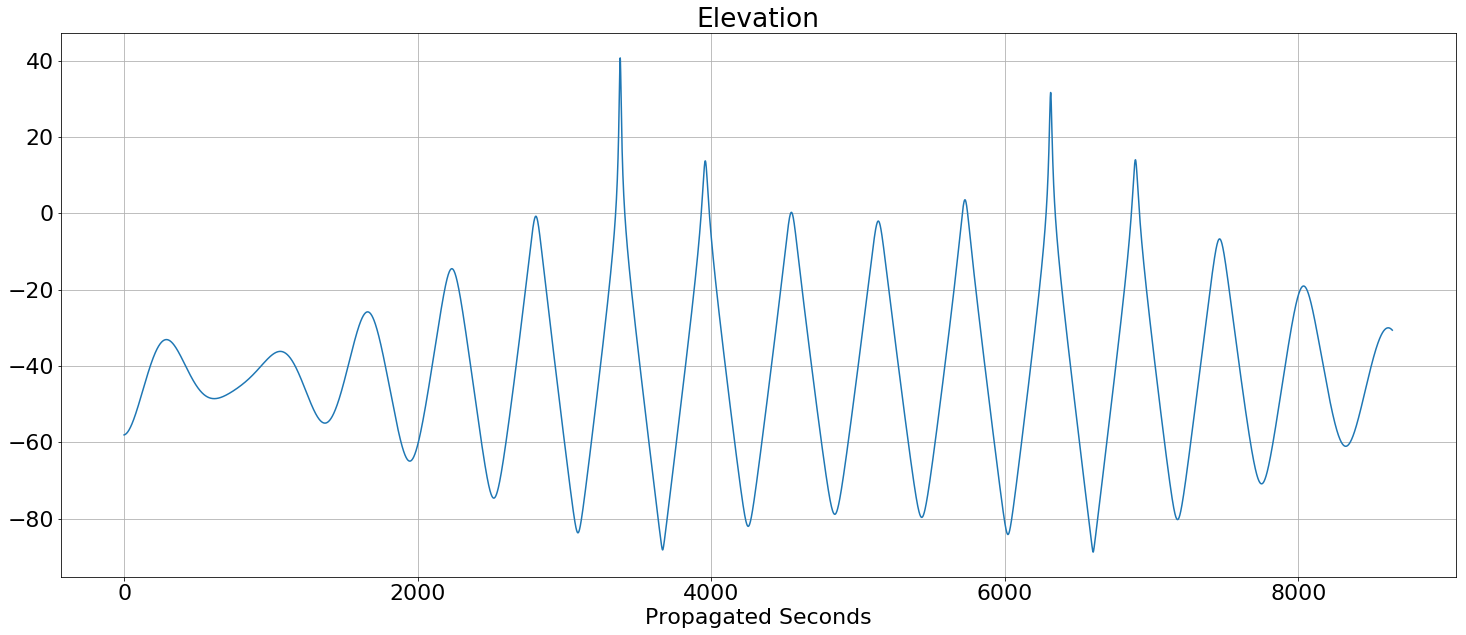

In [59]:
#plotting propagated elevation 
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(25,10))
plt.plot(elevation)
# ylim(0,90)
plt.xlabel('Propagated Seconds')
plt.title('Elevation')
plt.grid(True)

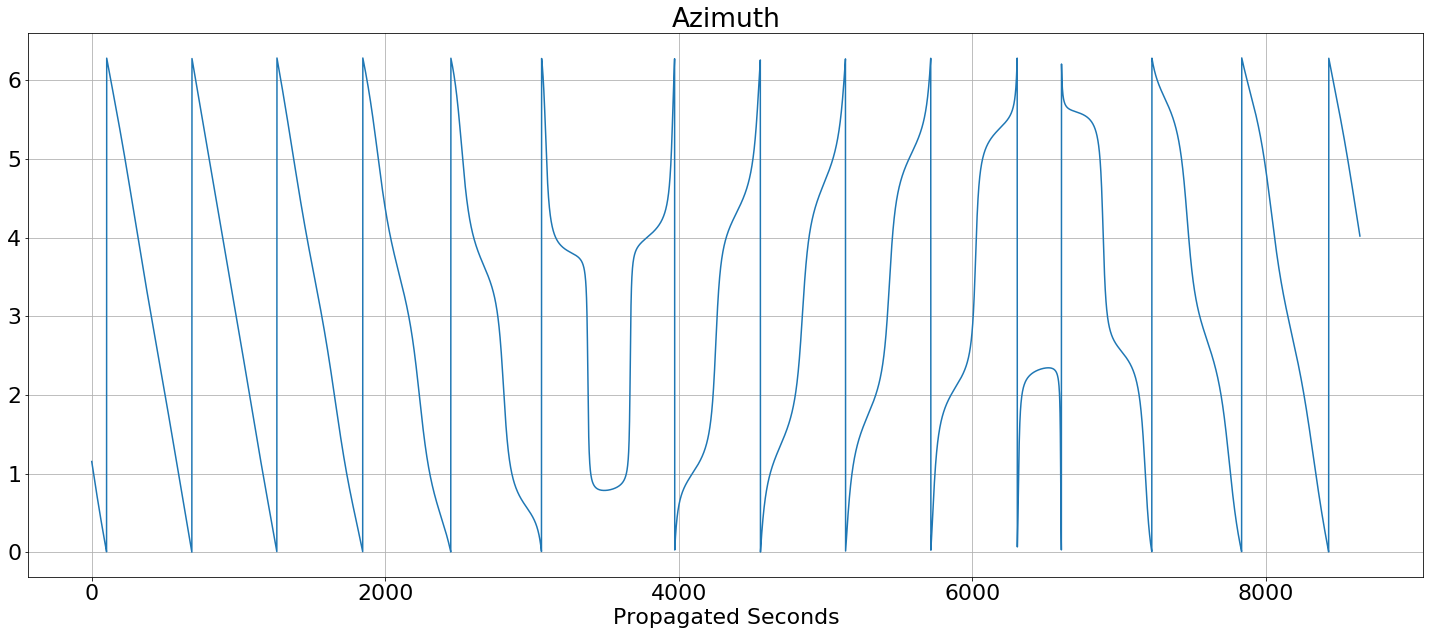

In [60]:
#plotting propagated azimuth 
plt.figure(figsize=(25,10))
plt.plot(azimuth)
# ylim(0,90)
plt.xlabel('Propagated Seconds')
plt.ylabel('')
plt.title('Azimuth')
plt.grid(True)

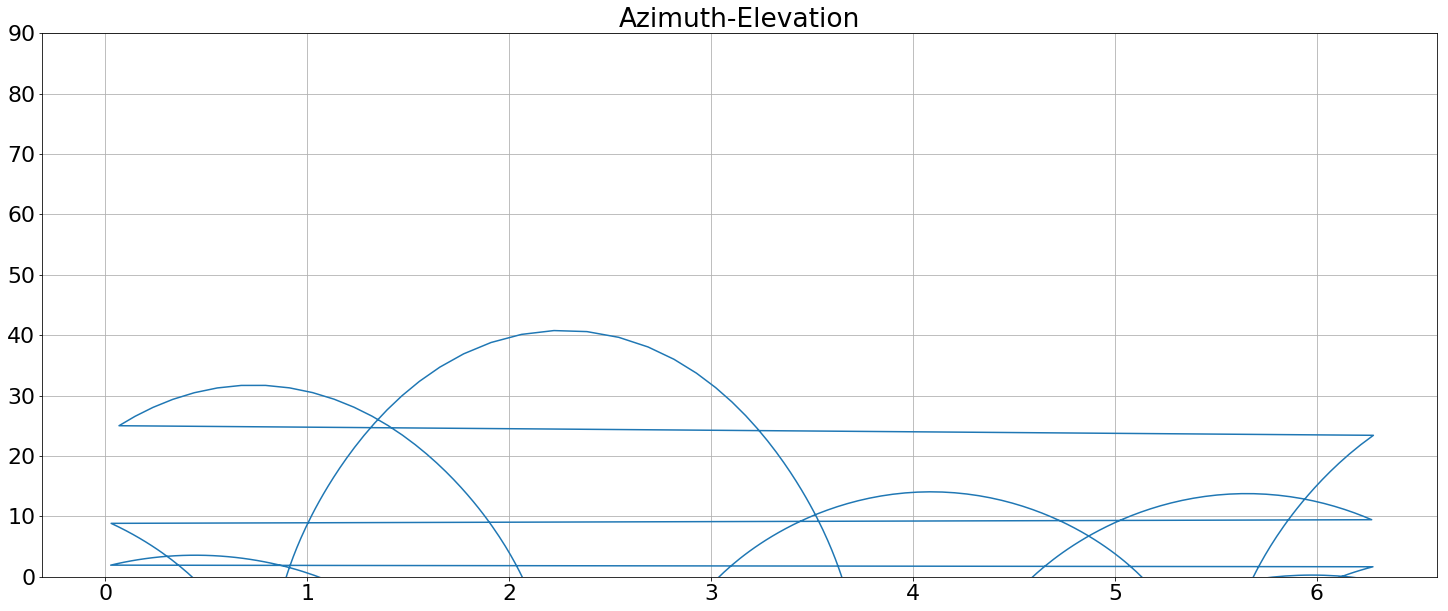

In [61]:
#plot the Azimuth and Elevation as the AZ-EL pair
plt.figure(figsize=(25,10))
plt.rcParams.update({'font.size': 22})
plt.plot(azimuth,elevation)
plt.ylim(0,90)
plt.title('Azimuth-Elevation')
plt.grid(True)

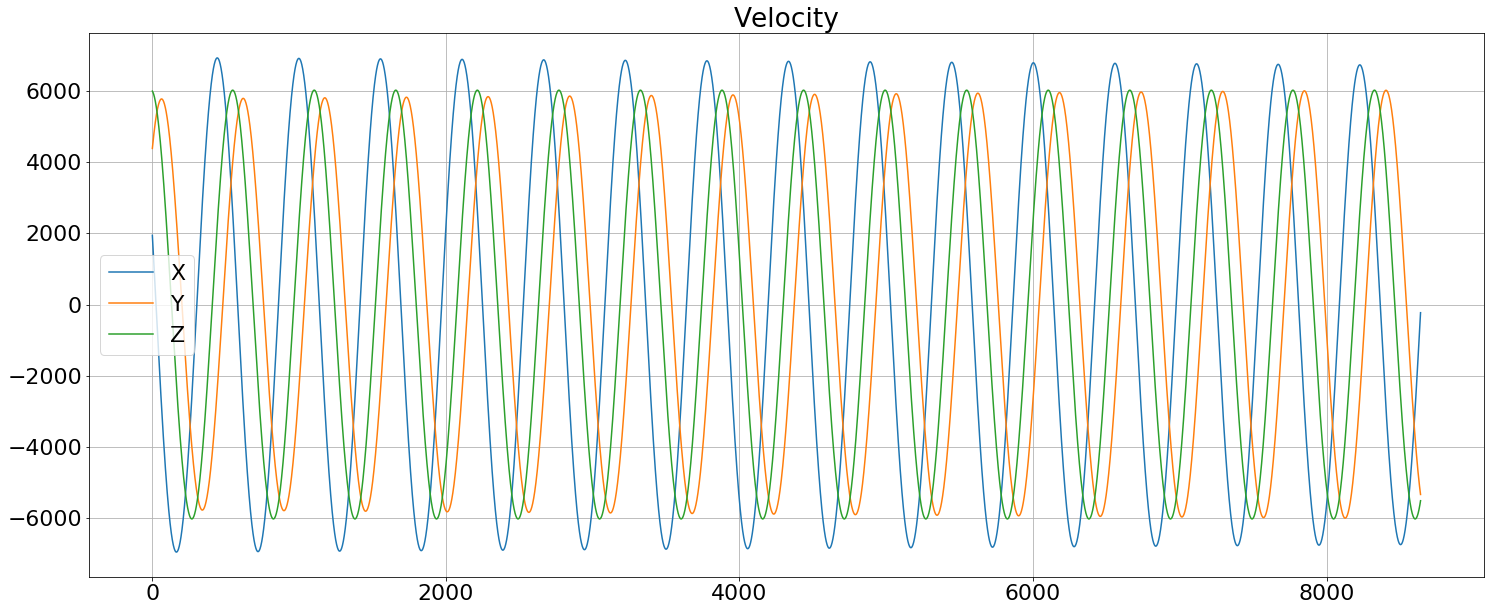

In [62]:
#plotting velocity

plt.figure(figsize=(25,10))
plt.rcParams.update({'font.size': 22})
plt.plot(velocity)
plt.title('Velocity')
plt.legend(['X', 'Y', 'Z'])
plt.grid(True)


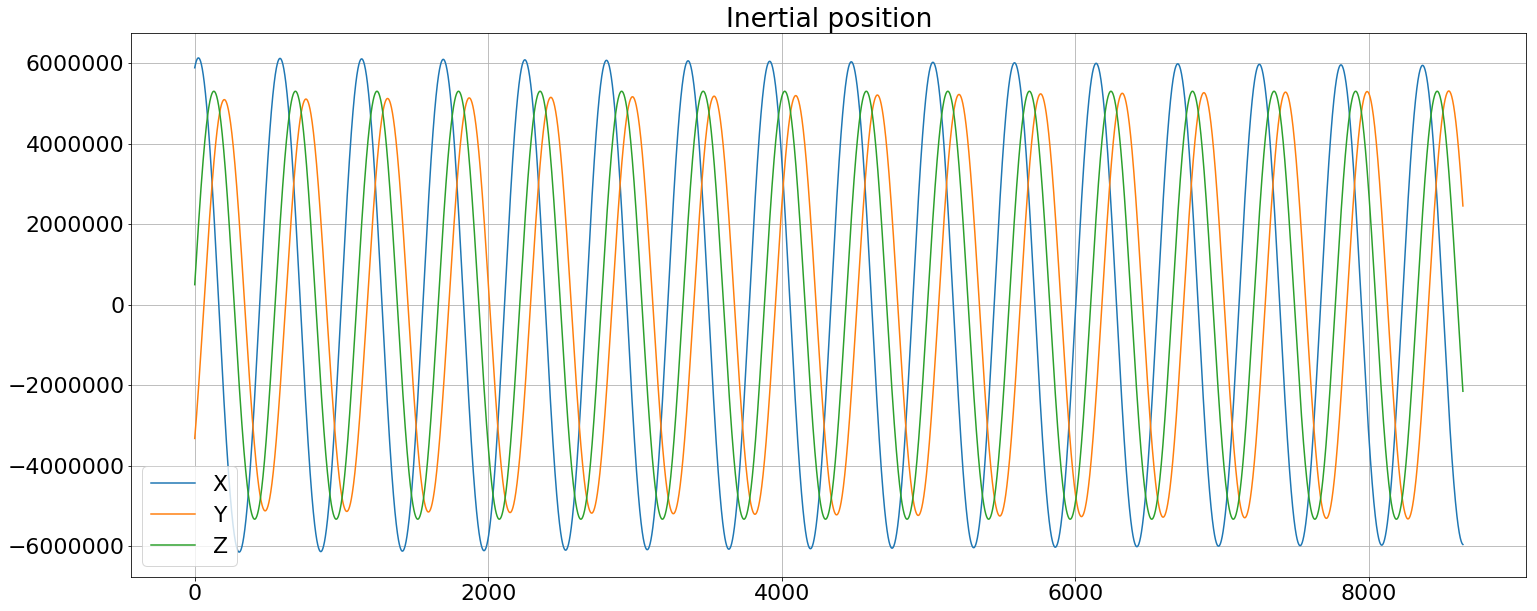

In [63]:
#plotting propagated position in 

plt.figure(figsize=(25,10))
plt.rcParams.update({'font.size': 22})
plt.plot(position) 
plt.title('Inertial position')
plt.grid(True)
plt.legend(['X', 'Y', 'Z'])
plt.show()



# 3D interactive plot of propagated orbit around earth 


In [64]:

#plot the orbit of the propagated TLE  
orbit = go.Scatter3d(
    x=pos_x, y=pos_y,z=pos_z,
    mode='markers',
    marker=dict(
        color='rgb(127, 127, 127)',
        size=2,
        symbol='circle'),
    name='Orbit')

#place a large blue scatter point in the centre of the frame to represent earth - not scaled. 
earth = go.Scatter3d(
    x=[0], y=[0], z=[0],
    mode='markers',
    marker=dict(
        size=70,
        opacity=1,
        color='rgb(0, 0, 128)'),
    name='Earth')

data = [orbit,earth]
layout = go.Layout(
    margin=dict(
        l=0, r=0, b=0, t=0),
     title='Propagated Orbit')

iplot(go.Figure(data=data, layout=layout))

# Plot the geographic position of the propagated orbit over earth 

AttributeError: can't set attribute

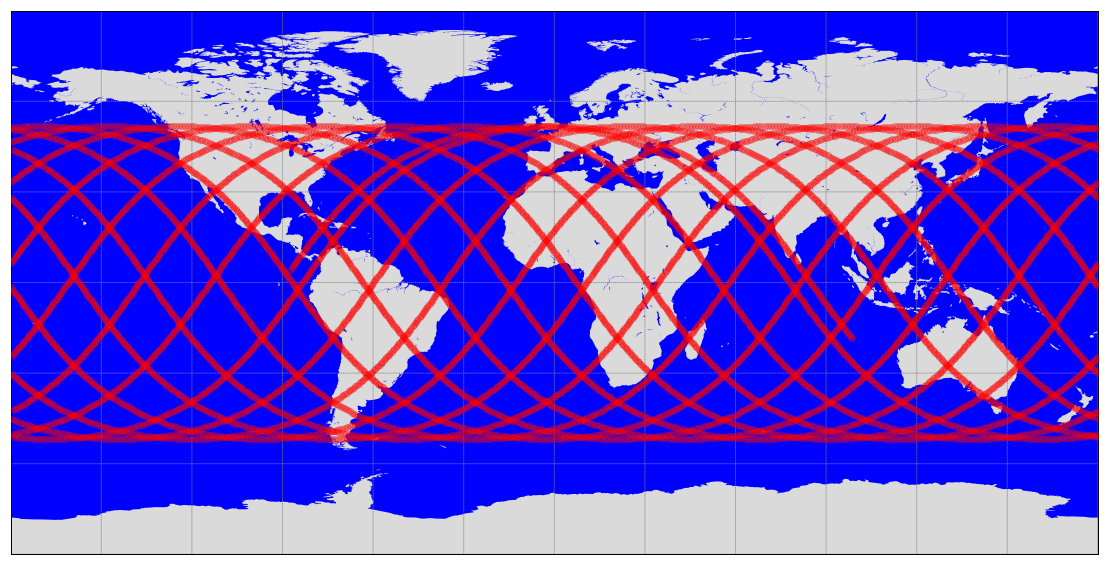

In [65]:
#Matplotlib will complain about Basemap, this is a minor version problem and does not affect the output 

plt.figure(figsize=(25,10))

m = Basemap(projection='cyl',
            resolution='l',
            area_thresh=None)

m.drawmapboundary(fill_color='blue') #blue ocean 
m.fillcontinents(color='#dadada', lake_color='blue') #grey land and blue lakes 
m.drawmeridians(np.arange(-180, 180, 30), color='gray')
m.drawparallels(np.arange(-90, 90, 30), color='gray')

#scatter plot latitude and longitude points per epoch over (z order 3) earth projection map 
m.scatter(longitude, latitude, alpha=0.3, color='red', zorder=3)